In [1]:
import numpy
import random

# Generate [n] random vectors with [d] dimension
# One will be selected randomly and label as 1, the rest as 0
def generate_dateset(d, n):
    x = numpy.random.uniform(-1, 1, (n, d))
    y = numpy.zeros(n)
    y[random.randrange(0, n)] = 1
    return x, y

X, Y = generate_dateset(5, 100)
print(X)
print(Y)

[[ 8.59463520e-01 -7.86655502e-01  2.75919393e-01 -7.60212694e-01
   1.67179817e-01]
 [ 4.11920156e-01  4.98910439e-01  3.05827001e-01 -4.80906779e-02
   9.13054386e-01]
 [-5.66204422e-01  7.06044059e-01 -6.37280088e-01  4.55364272e-01
  -2.03970430e-01]
 [ 2.27230596e-01 -3.53368143e-01  6.95894227e-01  1.90386709e-01
   2.38272920e-01]
 [-2.91164895e-01 -2.07117152e-01 -9.11649517e-01 -1.65721436e-01
   8.64626428e-01]
 [ 9.94671091e-01  9.98094037e-01  8.11129610e-01 -4.00522761e-01
  -9.85631205e-01]
 [-7.55141190e-01 -2.24878782e-01  2.40177588e-01  4.55961117e-01
   4.24379352e-02]
 [ 1.26255396e-01  4.35734824e-01  7.66533414e-01  5.38782750e-01
  -2.80439491e-01]
 [ 5.53941341e-02 -5.75671440e-01  1.79257437e-01 -1.60796801e-01
  -6.24295532e-01]
 [ 2.24334600e-01  8.68528679e-01  9.75592027e-01  7.24922835e-01
  -6.20596702e-01]
 [ 7.76235401e-01 -5.95484011e-01  9.34332932e-01 -6.78056183e-01
  -7.61086919e-01]
 [ 7.14307728e-01 -4.41348745e-01 -2.56354776e-01  1.20394414e-01

In [2]:
class Node:
    def __init__(self, data, children=None, backward_func=lambda out: None):
        self.data = data
        self.grad = 0
        self.children = children
        self.backward_func = backward_func

    def backward(self):
        self.grad = 1
        self.backward0(set())

    def backward0(self, visited):
        self.backward_func(self)
        if self.children is None: return

        for child in self.children:
            if child not in visited:
                visited.add(child)
                child.backward0(visited)

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)

        def backward_func0(out):
            self.grad += out.grad
            other.grad += out.grad

        return Node(self.data + other.data, [self, other], backward_func0)

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)

        def backward_func0(out):
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        return Node(self.data * other.data, [self, other], backward_func0)

    def __pow__(self, other):
        assert isinstance(other, (int, float))

        def backward_func0(out):
            self.grad += (other * self.data ** (other - 1)) * out.grad

        return Node(self.data ** other, [self], backward_func0)

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return -self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (1 / other)

    def __rtruediv__(self, other):
        return (1 / other) * self

    def __float__(self):
        return float(self.data)

a = Node(5)

def f(x): return (x + 2) ** 2 + x ** 3

y = f(a)
y.backward()
print(y.data, a.grad)

174 89


In [3]:
def random_node():
    return Node(random.uniform(-1, 1))

class Layer:
    def __init__(self, input_size, output_size, activation_func=lambda x: x):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_func = activation_func
        self.weights = [[random_node() for _ in range(input_size)] for _ in range(output_size)]
        self.bias = [random_node() for _ in range(output_size)]

    def __call__(self, inputs):
        y = [sum(w * x for w, x in zip(weights, inputs)) for weights in self.weights]
        y = [y + b for y, b in zip(y, self.bias)]
        y = [self.activation_func(y) for y in y]
        return y

class NeuralNetwork:
    def __init__(self, *layers):
        self.input_size = layers[0].input_size
        self.output_size = layers[-1].output_size
        self.layers = layers
        self.parameters = []
        for layer in layers:
            for w in layer.weights:
                self.parameters += w
            self.parameters += layer.bias

    def zero_grad(self):
        for p in self.parameters:
            p.grad = 0

    def update(self, learning_rate):
        for p in self.parameters:
            p.data -= p.grad * learning_rate

    def __call__(self, x):
        y = x
        for layer in self.layers:
            y = layer(y)
        return y

In [4]:
def relu(self: Node):
    def backward_func0(out):
        self.grad += (self.data > 0) * out.grad

    return Node(max(self.data, 0), [self], backward_func0)

# Testing relu function
x = Node(1)
y = 2 * (relu(2 * x ** 3)) ** 3
y.backward()
print(y.data, x.grad)

16 144


In [5]:
import matplotlib.pyplot as plt

def run_test_with_network(network, X, Y, max_epoch, learning_rate, print_result=False):
    n = len(Y)
    plot_epoch = []
    plot_loss = []

    for epoch in range(max_epoch):
        losses = []
        for x, y in zip(X, Y):
            y_pred = network(x)[0]
            if y == 0:
                loss = (y_pred - 0) ** 2
            else:
                loss = (y_pred - 1) ** 2 * n
            losses.append(loss)
        loss = sum(losses) / n
        network.zero_grad()
        loss.backward()
        network.update(learning_rate)

        plot_epoch.append(epoch)
        plot_loss.append(loss.data)

    if print_result:
        plt.plot(plot_epoch, plot_loss)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

    results = []

    for x, y in zip(X, Y):
        y_pred = network(x)[0]
        results.append([y_pred.data, y])

    results.sort(key=lambda x: x[0], reverse=True)
    ranking = 0

    for i, result in enumerate(results):
        if result[1] == 1:
            ranking = i
        if print_result:
            print(result)

    return ranking

In [6]:
dataset_n = 10
dataset_d = 5
max_epoch = 20
learning_rate = 0.1

X, Y = generate_dateset(dataset_d, dataset_n)
print(X)
print(Y)

[[ 0.31432776 -0.81858714 -0.49953734 -0.34752062  0.66854915]
 [-0.13818421  0.58019185  0.97252825 -0.99449448  0.54175851]
 [-0.66288063 -0.88190542  0.34262383 -0.59125927 -0.23400403]
 [ 0.94703099 -0.07446894  0.47117926  0.98237941  0.88603312]
 [ 0.01600063  0.42838862  0.96254517  0.86069428 -0.67517278]
 [-0.28488211  0.1949373   0.67936628  0.7118177  -0.78036342]
 [-0.03072662  0.12902433  0.46837499 -0.60029765  0.82360728]
 [ 0.14028928  0.41050052 -0.14331429 -0.01537051  0.03248958]
 [ 0.86385107 -0.44557975 -0.94095647 -0.47083448 -0.41050728]
 [-0.01773804 -0.83791393  0.88589821 -0.04612965  0.1737156 ]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


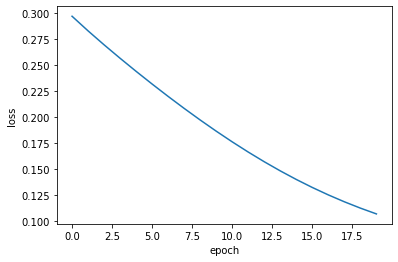

[0.8492767512326013, 1.0]
[0.6165107135202518, 0.0]
[0.40189215744588236, 0.0]
[0.3250329534002504, 0.0]
[0.30327241978638664, 0.0]
[0.21305110099714852, 0.0]
[0.07659912213779763, 0.0]
[-0.0004062609718529231, 0.0]
[-0.008832641948568365, 0.0]
[-0.02261734928310266, 0.0]


0

In [7]:
def run_test_with_activation_func(activation_func, print_result=False):
    network = NeuralNetwork(
        Layer(dataset_d, dataset_d, activation_func),
        Layer(dataset_d, dataset_d, activation_func),
        Layer(dataset_d, dataset_d, activation_func),
        Layer(dataset_d, 1),
    )

    return run_test_with_network(network, X, Y, max_epoch, learning_rate, print_result)

run_test_with_activation_func(relu, True)

In [8]:
def sigmoid(self: Node):
    def backward_func0(out):
        self.grad += (out.data * (1 - out.data)) * out.grad

    return Node(1 / (1 + numpy.exp(-self.data)), [self], backward_func0)

# Testing sigmoid function
x = Node(1)
y = 2 * (sigmoid(2 * x ** 3)) ** 3
y.backward()
print(y.data, x.grad)

1.3666508986890917 2.9323580491420715


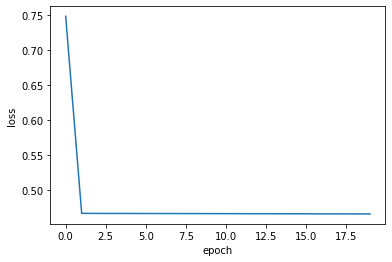

[0.546426133364746, 0.0]
[0.5392163271933398, 0.0]
[0.53070927928858, 1.0]
[0.5286413086114479, 0.0]
[0.526965880392658, 0.0]
[0.5190214574232628, 0.0]
[0.5182729194701814, 0.0]
[0.5172091471946244, 0.0]
[0.5037806055211645, 0.0]
[0.5020767580872079, 0.0]


2

In [9]:
run_test_with_activation_func(sigmoid, True)

In [10]:
result_size = 50
results_relu = [None] * result_size
results_sigmoid = [None] * result_size

for i in range(result_size):
    results_relu[i] = run_test_with_activation_func(relu)
    results_sigmoid[i] = run_test_with_activation_func(sigmoid)

print(results_relu)
print(results_sigmoid)

KeyboardInterrupt: 

In [ ]:
plt.hist(results_relu, range=(0, dataset_n))
plt.title("Relu")
plt.show()

plt.hist(results_sigmoid, range=(0, dataset_n))
plt.title("Sigmoid")
plt.show()